In [15]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import sys
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM
from keras.regularizers import l1, l2, l1_l2
from keras.models import load_model


module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.transformers import LinearTransformation, ParabolicTransformation, TrigTransformation
from src.preprocessing import *
from src.sliding_window import *
from src.models import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Global Var
sliding_window_size = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

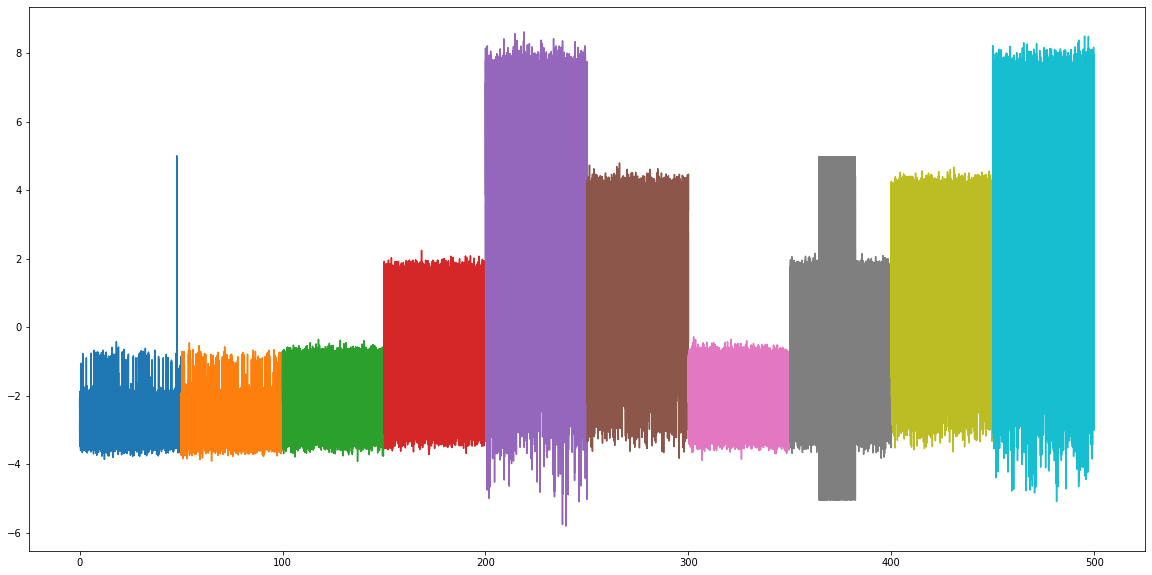

In [3]:
train_chunks = chunk_data(full_data, 10)

lt = LinearTransformation()
pt = ParabolicTransformation()
tt = TrigTransformation(trig_function = 'sin')

train_chunks[1].loc[train_chunks[1].index[:100000], 'signal'] = lt.fit_transform(train_chunks[1][:100000], 3/10, -15)
train_chunks[6]['signal'] = tt.fit_transform(train_chunks[6], 300, 50, 4.95)
train_chunks[7]['signal'] = tt.fit_transform(train_chunks[7], 350, 50, 5.030)
train_chunks[8]['signal'] = tt.fit_transform(train_chunks[8], 400, 50, 4.974)
train_chunks[9]['signal'] = tt.fit_transform(train_chunks[9], 450, 50, 5.089)

plt.figure(figsize = (20, 10))
for i in train_chunks:
    plt.plot(i['time'], i['signal'])

In [4]:
# plt.figure(figsize = (20, 10))
# for chunk in train_chunks:
#     a = chunk

#     wind = 1000

#     b = a.rolling(wind).min()
#     b['signal'] = b['signal'].mean()


#     c = a.rolling(wind).max()
#     c['signal'] = c['signal'].mean()

#     print(b['signal'].mean(), c['signal'].mean())
#     plt.plot(a['time'], a['signal'])
#     plt.plot(b['time'], b['signal'], linewidth = 3)
#     plt.plot(c['time'], c['signal'], linewidth = 3)






# plt.figure(figsize = (20, 10))
# for chunk in test_chunks:
#     a = chunk

#     wind = 1000

#     b = a.rolling(wind).min()
#     b['signal'] = b['signal'].mean()


#     c = a.rolling(wind).max()
#     c['signal'] = c['signal'].mean()

    
#     plt.plot(a['time'], a['signal'])
#     plt.plot(b['time'], b['signal'], linewidth = 3)
#     plt.plot(c['time'], c['signal'], linewidth = 3)
    


In [5]:
'''
class MinMaxTransformer():
    def __init__(self):
        pass
    
    
    def fit(self, training_data):
        self.training_data = training_data
        return self
    
    
    def transform(self, data):
        array = np.array(data)
        x = array[:, 0]
        y = array[:, 1]
        return y - (self.slope * x + self.intercept)
    
    
    def fit_transform(self, training_data, data):
        self.fit(training_data)
        return self.transform(data)
#'''

'\nclass MinMaxTransformer():\n    def __init__(self):\n        pass\n    \n    \n    def fit(self, training_data):\n        self.training_data = training_data\n        return self\n    \n    \n    def transform(self, data):\n        array = np.array(data)\n        x = array[:, 0]\n        y = array[:, 1]\n        return y - (self.slope * x + self.intercept)\n    \n    \n    def fit_transform(self, training_data, data):\n        self.fit(training_data)\n        return self.transform(data)\n#'

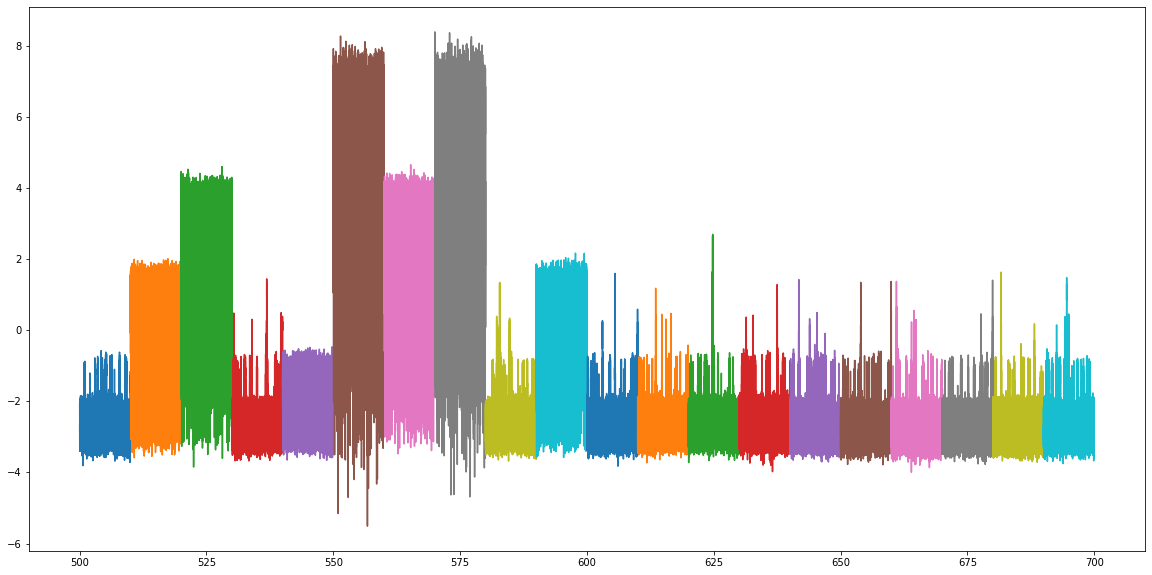

In [6]:
test_chunks = chunk_data(test_data, 4)
test_chunks = chunk_data(test_chunks[0], 5) + chunk_data(test_chunks[1], 5) + test_chunks[2:]

test_chunks[0]['signal'] = lt.fit_transform(test_chunks[0], 3 / 10, -150)
test_chunks[1]['signal'] = lt.fit_transform(test_chunks[1], 3 / 10, -153)
test_chunks[4]['signal'] = lt.fit_transform(test_chunks[4], 3 / 10, -162)
test_chunks[6]['signal'] = lt.fit_transform(test_chunks[6], 3 / 10, -168)
test_chunks[7]['signal'] = lt.fit_transform(test_chunks[7], 3 / 10, -171)
test_chunks[8]['signal'] = lt.fit_transform(test_chunks[8], 3 / 10, -174)
test_chunks[10]['signal'] = tt.fit_transform(test_chunks[10], 600, 50, 4.925)

test_chunks = test_chunks[:10] + chunk_data(pd.concat(test_chunks[10:]), 10)

plt.figure(figsize = (20, 10))
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

In [7]:
# model5_train = train_chunks[4]
# model5_train = make_sliding_window_frame(model5_train, sliding_window_size)

# model5_test = train_chunks[9]
# model5_test = make_sliding_window_frame(model5_test, sliding_window_size)

# nn = BasicNN(sliding_window_size)
# model5 = nn.get_trained_model(model5_train, cycles = 20, epochs = 2)

In [8]:
# f1_score(model5_test['open_channels'], model5.predict_classes(model5_test.drop(['open_channels'], axis = 1) + 0.06), average = 'macro')

In [9]:
model1_data = pd.concat([train_chunks[0], train_chunks[1]])
model1_data = make_sliding_window_frame(model1_data, sliding_window_size)

model2_data = pd.concat([train_chunks[2], train_chunks[6]])
model2_data = make_sliding_window_frame(model2_data, sliding_window_size)

model3_data = pd.concat([train_chunks[3]])
# model3_data = pd.concat([train_chunks[3], train_chunks[7]])
model3_data = make_sliding_window_frame(model3_data, sliding_window_size)

model4_data = pd.concat([train_chunks[5], train_chunks[8]])
model4_data = make_sliding_window_frame(model4_data, sliding_window_size)

model5_data = pd.concat([train_chunks[4], train_chunks[9]])
model5_data = make_sliding_window_frame(model5_data, sliding_window_size)

In [10]:
nn = BasicNN(sliding_window_size)
model1 = nn.get_trained_model(model1_data, cycles = 8, epochs = 2)
print('\n\n')
time.sleep(300)
model2 = nn.get_trained_model(model2_data, cycles = 8, epochs = 2)
print('\n\n')
time.sleep(300)
model3 = nn.get_trained_model(model3_data, cycles = 10, epochs = 2)
print('\n\n')
time.sleep(300)
model4 = nn.get_trained_model(model4_data, cycles = 15, epochs = 2)
print('\n\n')
time.sleep(300)
model5 = nn.get_trained_model(model5_data, cycles = 20, epochs = 2)

Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 8s 12us/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0057 - val_accuracy: 0.9981
Epoch 2/2
650000/650000 [==============================] - 8s 12us/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0036 - val_accuracy: 0.9989
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 8s 12us/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0018 - val_accuracy: 0.9994
Epoch 2/2
650000/650000 [==============================] - 7s 12us/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0018 - val_accuracy: 0.9994
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 12us/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 2/2
650000/650000 [==============================] - 8s 12us/step - loss: 0.0022 - accuracy: 0.999

In [31]:
model1_layer0 = model1
model2_layer0 = model2
model3_layer0 = model3
model4_layer0 = model4
model5_layer0 = model5

In [49]:
def get_next_input_space(model, data):
    next_input_space = model.predict_classes(data.drop(['open_channels'], axis = 1))
    next_input_space = pd.Series(next_input_space, name = '')
    next_input_space = make_sliding_window_series(next_input_space, sliding_window_size)
    next_input_space['open_channels'] = data['open_channels']
    return next_input_space

In [50]:
model1_input_space_1 = get_next_input_space(model1_layer0, model1_data)
model2_input_space_1 = get_next_input_space(model2_layer0, model2_data)
model3_input_space_1 = get_next_input_space(model3_layer0, model3_data)
model4_input_space_1 = get_next_input_space(model4_layer0, model4_data)
model5_input_space_1 = get_next_input_space(model5_layer0, model5_data)

In [51]:
model1_layer1 = nn.get_trained_model(model1_input_space_1, cycles = 8, epochs = 2)

Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0251 - accuracy: 0.9988 - val_loss: 0.0027 - val_accuracy: 0.9996
Epoch 2/2
650000/650000 [==============================] - 8s 12us/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0027 - val_accuracy: 0.9996
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 0.9995
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0023 - val_accuracy: 0.9996
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0027 - accuracy: 0.999

In [53]:
time.sleep(300)
model2_layer1 = nn.get_trained_model(model2_input_space_1, cycles = 5, epochs = 2)

Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0316 - accuracy: 0.9931 - val_loss: 0.0161 - val_accuracy: 0.9974
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0158 - accuracy: 0.9974 - val_loss: 0.0172 - val_accuracy: 0.9974
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0158 - accuracy: 0.9974 - val_loss: 0.0155 - val_accuracy: 0.9975
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0156 - accuracy: 0.9974 - val_loss: 0.0153 - val_accuracy: 0.9975
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0157 - accuracy: 0.9974 - val_loss: 0.0154 - val_accuracy: 0.9975
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0157 - accuracy: 0.997

In [54]:
time.sleep(300)
model3_layer1 = nn.get_trained_model(model3_input_space_1, cycles = 5, epochs = 2)

Train on 325000 samples, validate on 175000 samples
Epoch 1/2
325000/325000 [==============================] - 4s 11us/step - loss: 0.1295 - accuracy: 0.9664 - val_loss: 0.0709 - val_accuracy: 0.9875
Epoch 2/2
325000/325000 [==============================] - 4s 11us/step - loss: 0.0725 - accuracy: 0.9878 - val_loss: 0.0701 - val_accuracy: 0.9877
Train on 325000 samples, validate on 175000 samples
Epoch 1/2
325000/325000 [==============================] - 4s 11us/step - loss: 0.0701 - accuracy: 0.9879 - val_loss: 0.0692 - val_accuracy: 0.9875
Epoch 2/2
325000/325000 [==============================] - 4s 11us/step - loss: 0.0688 - accuracy: 0.9880 - val_loss: 0.0691 - val_accuracy: 0.9875
Train on 325000 samples, validate on 175000 samples
Epoch 1/2
325000/325000 [==============================] - 4s 11us/step - loss: 0.0691 - accuracy: 0.9878 - val_loss: 0.0681 - val_accuracy: 0.9878
Epoch 2/2
325000/325000 [==============================] - 4s 11us/step - loss: 0.0686 - accuracy: 0.987

In [55]:
time.sleep(300)
model4_layer1 = nn.get_trained_model(model4_input_space_1, cycles = 5, epochs = 2)

Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.2083 - accuracy: 0.9438 - val_loss: 0.1232 - val_accuracy: 0.9758
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.1292 - accuracy: 0.9758 - val_loss: 0.1233 - val_accuracy: 0.9758
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.1274 - accuracy: 0.9758 - val_loss: 0.1226 - val_accuracy: 0.9761
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.1262 - accuracy: 0.9758 - val_loss: 0.1219 - val_accuracy: 0.9761
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.1250 - accuracy: 0.9759 - val_loss: 0.1227 - val_accuracy: 0.9759
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.1243 - accuracy: 0.976

In [52]:
time.sleep(300)
model5_layer1 = nn.get_trained_model(model5_input_space_1, cycles = 10, epochs = 2)

Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 8s 12us/step - loss: 0.6430 - accuracy: 0.7917 - val_loss: 0.4526 - val_accuracy: 0.8802
Epoch 2/2
650000/650000 [==============================] - 8s 12us/step - loss: 0.4509 - accuracy: 0.8786 - val_loss: 0.4569 - val_accuracy: 0.8800
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.4440 - accuracy: 0.8801 - val_loss: 0.4556 - val_accuracy: 0.8801
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.4405 - accuracy: 0.8804 - val_loss: 0.4281 - val_accuracy: 0.8800
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.4390 - accuracy: 0.8805 - val_loss: 0.4277 - val_accuracy: 0.8803
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.4381 - accuracy: 0.880

In [64]:
def _predict(model, test_data):
    #y_predictions = model.predict_classes(make_sliding_window(test_data['signal'], sliding_window_size))
    y_predictions = model.predict_classes(test_data)
    #return pd.DataFrame({'time' : test_data['time'].values, 'open_channels' : y_predictions})
    return y_predictions

In [65]:
def predict(model_layer_1, model_layer_2, data_layer_0):
    first_input_space = make_sliding_window_series(data_layer_0['signal'], sliding_window_size)
    next_input_space = _predict(model_layer_1, first_input_space)
    next_input_space = pd.Series(next_input_space, name = '')
    next_input_space = make_sliding_window_series(next_input_space, sliding_window_size)
    return pd.DataFrame({'time' : data_layer_0['time'].values, 'open_channels' : _predict(model_layer_2, next_input_space)})

In [20]:
model1.save('NN_model1.h5')
model2.save('NN_model2.h5')
model3.save('NN_model3.h5')
model4.save('NN_model4.h5')
model5.save('NN_model5.h5')

In [66]:
predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[0])])
predictions = pd.concat([predictions, predict(model3_layer0, model3_layer1, test_chunks[1])])
predictions = pd.concat([predictions, predict(model4_layer0, model4_layer1, test_chunks[2])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[3])])
predictions = pd.concat([predictions, predict(model2_layer0, model2_layer1, test_chunks[4])])
predictions = pd.concat([predictions, predict(model5_layer0, model5_layer1, test_chunks[5])])
predictions = pd.concat([predictions, predict(model4_layer0, model4_layer1, test_chunks[6])])
predictions = pd.concat([predictions, predict(model5_layer0, model5_layer1, test_chunks[7])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[8])])
predictions = pd.concat([predictions, predict(model3_layer0, model3_layer1, test_chunks[9])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[10])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[11])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[12])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[13])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[14])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[15])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[16])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[17])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[18])])
predictions = pd.concat([predictions, predict(model1_layer0, model1_layer1, test_chunks[19])])

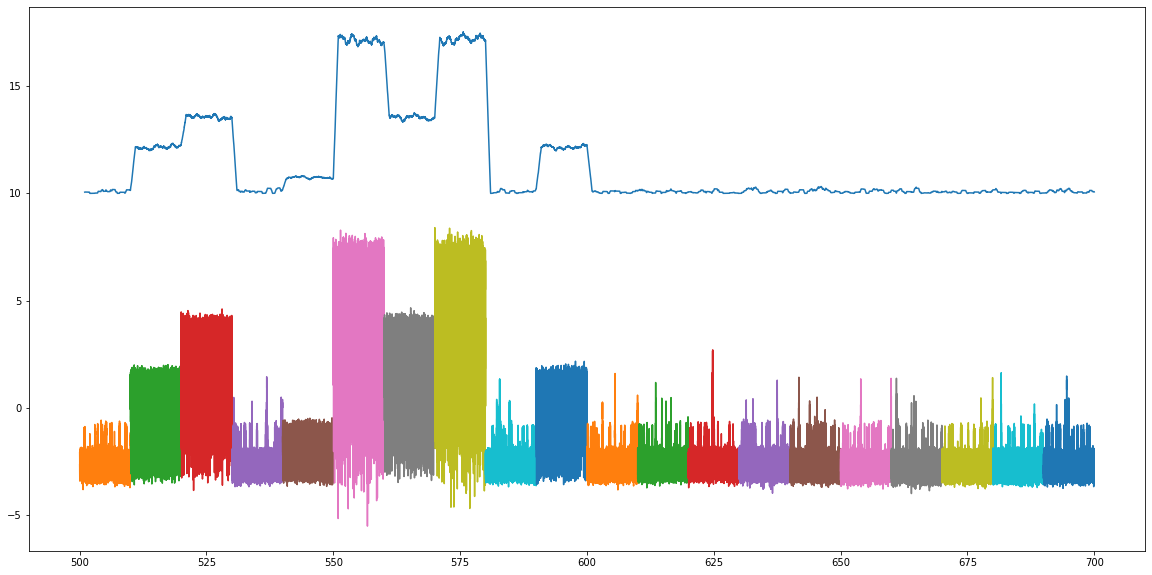

In [67]:
plt.figure(figsize = (20, 10))
plt.plot(predictions['time'], predictions['open_channels'].rolling(10000).mean() + 10)
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

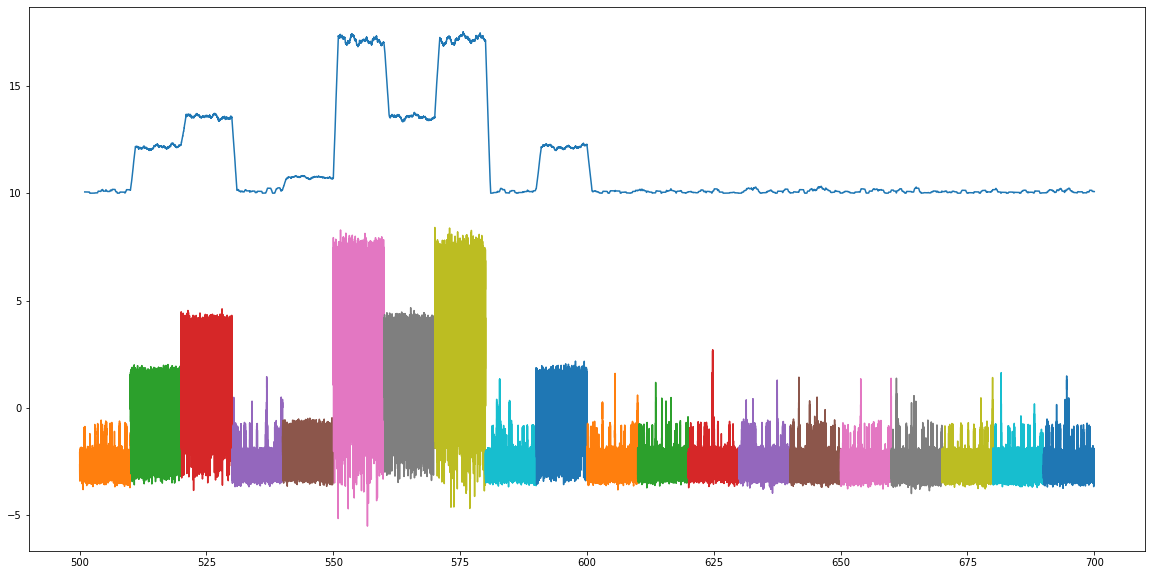

In [18]:
plt.figure(figsize = (20, 10))
plt.plot(predictions['time'], predictions['open_channels'].rolling(10000).mean() + 10)
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

In [69]:
predictions.to_csv('~/Desktop/test_predictions2.csv', index = False, float_format='%.4f')
#0.937 preds_12